# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
import networkx as nx
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from tqdm import tqdm
from time import time, sleep

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
vx_sizes = [16, 16, 30]

def get_viewer(backgnd_color = "black"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[17000,17000,1500]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = array(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer

def create_baseseg_layer(viewer, source, lname, visible = False, objectAlpha = 1):
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.SegmentationLayer(source = source, segments=[], segment_colors={})
        s.layers[lname].ignoreNullVisibleSet = False
        s.layers[lname].pick = True
        s.layers[lname].selectedAlpha = 0.5 #For 2D
        s.layers[lname].objectAlpha = objectAlpha
        s.layers[lname].visible = visible
                 

def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)

def clear_baseseg_layer(viewer, lname):
    displayed_segs = set([str(x) for x in viewer.state.layers[lname].segments])

    # REMOVE SEGMENTS FROM NGviewer
    remove_segs = displayed_segs

    with viewer.txn(overwrite=True) as s:
        for bs in remove_segs:
            if int(bs) in s.layers[lname].segments:
                s.layers[lname].segments.remove(int(bs))

def point_on_line(u, v, d):
    delta_x = v[0] - u[0]
    delta_y = v[1] - u[1]
    length = (delta_x**2 + delta_y**2)**0.5  # Length of the line segment between u and v
    if length == 0:
        return u  # Return u if u and v coincide
    scaling_factor = d / length
    p = (u[0] + scaling_factor * delta_x, u[1] + scaling_factor * delta_y)
    return p

# Create custom arrow style as a function
def arrow_style(posA, posB, mutation_size, linewidth, linestyle, color):
    line1 = [(0, 0), (1, 0)]
    line2 = [(0, -0.2), (1, 0.2)]
    return patches.FancyArrowPatch(posA, posB, arrowstyle=patches.ArrowStyle.Simple(tail_width=linewidth, head_width=mutation_size, head_length=mutation_size * 2),
                                   color=color, linewidth=linewidth, linestyle=linestyle, mutation_scale=mutation_size,alpha = 0.5)


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

db_cursors = sqlite3_connect(settings_dict['db_path'], check_same_thread=False).cursor()

a = ', '.join(['base_address'])

db_cursors.execute(f'''SELECT {a} FROM addresses_table LIMIT 1''')

[base_seg] = db_cursors.fetchall()[0]


# Load files

## mg_network file names

In [4]:
dirpath = Path(settings_dict['save_dir'])


In [5]:
nodefiles = get_cell_filepaths(dirpath)

## df_syn pre or post

In [6]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [7]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

In [109]:
if syn == 'pre-synaptic':
    df_syn.drop(df_syn[df_syn['pre'].isin([299392199,386392158,472361842,389085521,227254070,228321391,403522169,313068329,126649726])].index, inplace=True)

In [183]:
# df_syn.loc[df_syn['pre']==285761792,'pre_type']='pe'

### --> df_edges

In [8]:
# remove structure and soma diameter information if want to
df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

df_edges=df_syn.value_counts().reset_index(name='weight')

In [9]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [321]:
df_edges.head(4)

,pre,post,pre_type,post_type,weight
0,130781211,215526370,sg2,lg,32
1,306461085,301863996,sg2,lg,32
2,473631846,305332461,mg2,lg,30
3,300131090,392814322,mg1,lf,29


## Combined df_syn

In [6]:
df_post = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
df_pre = pd.read_csv(dirpath / 'graphs/df_presyn.csv')



In [7]:
df_pre.loc[df_pre['post_type'].isin(['dml']),'post_type']='mli'
df_pre.loc[df_pre['pre_type'].isin(['dml']),'pre_type']='mli'
df_post.loc[df_post['post_type'].isin(['dml']),'post_type']='mli'
df_post.loc[df_post['pre_type'].isin(['dml']),'pre_type']='mli'

In [8]:
df_pre = df_pre.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})

## --> df_edges

In [9]:
df_edges_pre=df_pre.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

df_edges_post=df_post.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [10]:
df_edges = deepcopy(df_edges_post)

## if want to keep any information that might differ between the two dataframes, use the following code first to rename columns in df_edges_pre to match df_edges
# df_edges_pre = df_edges_pre.rename(columns={'pre_type': 'pre_type_x', 'post_type': 'post_type_x', 'weight': 'weight_x'})

# Than use combine_first to merge the DataFrames
df_edges = df_edges_post.set_index(['pre', 'post']).combine_first(df_edges_pre.set_index(['pre', 'post'])).reset_index()

In [11]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [12]:
# Display the final DataFrame
df_edges.head(4)

,pre,post,post_type,pre_type,weight
0,23379765,128832297,sg1,pe,1
1,23379765,218095913,sg2,pe,1
2,23379765,299496636,mg1,pe,2
3,23379765,305051491,grc-s,pe,1


### check the overlap between pre and post and compare to combined

In [156]:
df_edges_pre[(df_edges_pre['post_type'].isin(['lg'])) & (df_edges_pre['pre_type'].isin(['mg2']))].sort_values(by = 'pre')

,post,pre,post_type,pre_type,weight
349,301787806,40665046,lg,mg2,2
209,301787806,129030308,lg,mg2,3
183,301787806,213605530,lg,mg2,4
223,301787806,214581797,lg,mg2,3
346,301787806,299404889,lg,mg2,2
56,301787806,300689181,lg,mg2,7
1585,301787806,472284925,lg,mg2,1
179,301787806,472361842,lg,mg2,4
125,301787806,472517114,lg,mg2,5
116,301787806,473631846,lg,mg2,5


In [157]:
df_edges_post[(df_edges_post['post'].isin([301787806])) & (df_edges_post['pre_type'].isin(['mg2']))]

,pre,post,pre_type,post_type,weight
283,213605530,301787806,mg2,lg,7
354,214581797,301787806,mg2,lg,6
374,300689181,301787806,mg2,lg,6
396,472517114,301787806,mg2,lg,6
573,473631846,301787806,mg2,lg,4
627,472361842,301787806,mg2,lg,4
718,129030308,301787806,mg2,lg,4
873,472284925,301787806,mg2,lg,3
944,299404889,301787806,mg2,lg,3
1049,558300217,301787806,mg2,lg,3


## Cell features to add

### Soma diameter

In [896]:
soma_diam = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])/1000
        if len(soma_anno)!=4:
            soma_diam[x] = np.NaN
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN


In [ ]:

for i,r in df_syn.iterrows():
    df_syn.loc[i,'pre_diam']=soma_diam[str(df_syn.loc[i,'pre'])]
    df_syn.loc[i,'post_diam']=soma_diam[str(df_syn.loc[i,'post'])]
df_syn.loc[:,'diam_diff'] = (df_syn['post_diam']-df_syn['pre_diam'])/df_syn['pre_diam']


In [900]:
soma_diam['216004541']

9.901

# Cell types dict from df_edges

In [16]:
cell_types = {}

for i,r in df_edges.iterrows():
    cell_types[r['pre']]=r['pre_type'].lower()
    cell_types[r['post']]=r['post_type'].lower()
    


# Completeness of synapses

In [12]:
all_types = set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','soma-diam','n_syn','done','todo','completed'])
for c in df_edges['pre'].unique():
    
    if (df_edges[df_edges['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_edges[df_edges['pre'].isin([c])]
        n_syn_done = c_df['weight'].sum()

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
        
        if len(cell.cell_data['end_points'][syn])>0:
            # try:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_types[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': n_syn_done, #len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - n_syn_done, #len(c_df),
                'completed': n_syn_done / (len(cell.cell_data['end_points'][syn]))
                }
            # except:
            #     print(f'error on {c}')
            #     continue
        
        if len(cell.cell_data['end_points'][syn])==0:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_types[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': np.NaN,
                'done': n_syn_done, #len(c_df),
                'todo': np.NaN, #len(c_df),
                'completed': np.NaN
                }
            # print(f'error on {c}')
            # continue

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [827]:
# df_progress

# Filtered edges

In [13]:
# Filter by pre and/or post cell type

network_types = ['mg1','mg2','lg','lf']#(set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique())) - set(['glia']) #,'dml','tsd']) #'tsd','dml','sgx1','sgx2'])

df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))] #- set(['lg','lf'])



In [14]:
df_edges = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]

In [877]:
# Filter by completeness of synaptic reconstructions

if syn=='post':
    df_edges_completed = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
    df_edges = pd.concat(df_edges_completed,df_edges[df_edges['pre_type'].isin(['aff'])])
    
    
if syn=='pre':
    df_edges = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]
    # df_syn.rename(columns={'pre_type':'post_type','post_type':'pre_type'}, inplace=True)

# df_edges --> all_connections

mean connection quantifications

In [73]:
'''
# If wanted to do mean among only cells that made each type of connection...

# Group by 'pre_type', 'post_type', and 'pre', count unique 'post', then reset index
result_df = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().reset_index()

# Group by 'pre_type' and 'post_type', calculate the mean of 'post' counts and rename the column
result_df.groupby(['pre_type', 'post_type'])['post'].mean().reset_index().rename(columns={'post': 'n_post'})'''


# calculates mean by dividing by total number of pre cells (labeled with syn and post reconstructed)

result_df = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

n_post = df_edges.groupby(['pre_type', 'post_type']).nunique().reset_index()[['pre_type','post_type','post']].rename(columns={'post':'n_post'})

result_df['n_post']=n_post['n_post']

n_cells = df_edges.groupby(['pre_type'])['pre'].nunique().reset_index()#res.groupby('pre_type')['weight'].sum()
n_cells = n_cells.rename(columns={'pre': 'n_pre'})
# np.round(result_df.weight / denom)
merged_df = pd.merge(result_df, n_cells, on='pre_type', how='left')

n_cells = df_edges.groupby(['post_type'])['post'].nunique().reset_index()#res.groupby('pre_type')['weight'].sum()
n_cells = n_cells.rename(columns={'post': 'n_post'})

# Calculate the mean weight from pre to post for each pre_type-post_type category
merged_df['mean_weight'] = (merged_df['weight'] / merged_df['n_pre'])#.apply(lambda x: '%.1f' % x)

merged_df['mean_cells'] =(merged_df['n_post'] / merged_df['n_pre'])#.apply(lambda x: '%.1f' % x)

# Drop unnecessary columns if needed
final_result = deepcopy(merged_df)#[['pre_type', 'post_type', 'mean_weight','mean_post']])

# Display the result
# final_result.head()

For postsynaptic reconstructions, just use result_df

In [74]:
syn='post-synaptic'
final_result.loc[:,'direction']=syn

all_connections = final_result

For presynaptic reconstructions, need to switch pre and post columns of result df

In [585]:
final_result.loc[:,'direction']=syn
final_result.rename(columns={'pre_type':'post_type','post_type':'pre_type','n_post':'n_pre','n_pre':'n_post'}, inplace=True)

all_connections = final_result

In [500]:
## if merge pre and post results

# all_connections = pd.concat([all_connections,result_df])

## Create graph from all_connections

In [75]:
all_connections.head()#[all_connections['pre_type'].isin(['grc-d'])]

,pre_type,post_type,weight,n_post,n_pre,mean_weight,mean_cells,direction
0,mg1,lf,893,35,29,30.793103,1.206897,post-synaptic
1,mg1,lg,25,6,29,0.862069,0.206897,post-synaptic
2,mg1,mg1,22,7,29,0.758621,0.241379,post-synaptic
3,mg1,mg2,355,41,29,12.241379,1.413793,post-synaptic
4,mg2,lf,44,2,24,1.833333,0.083333,post-synaptic


In [76]:

G = nx.DiGraph()  # Create a directed graph

# nodes_to_add = set(all_connections['pre_type'].unique())|set(all_connections['post_type'].unique())
G.add_nodes_from(set(all_connections['pre_type'].unique())|set(all_connections['post_type'].unique()))

for index, row in all_connections.iterrows():
    pre_type = row['pre_type']
    post_type = row['post_type']
    n_cells = row['mean_cells']
    u_weight = row['mean_weight']#.asfloat()
    direction = row['direction']

    if direction == 'pre-synaptic':
        edge_color = 'purple'
    if direction == 'post-synaptic':
        edge_color = 'green'

    G.add_edge(pre_type, post_type, weight=u_weight, color=edge_color)


If want all pathways in connectivity dataframe

In [77]:
subgraph = G

If want pathways from only certain origin types

In [78]:
selected_origin_types = ['mg1','mg2'] #'grc-d','grc-s','sg1','sg2','aff',

# Filter edges based on the selected origin types
filtered_edges = [(u, v) for u, v in G.edges() if u in selected_origin_types]

# Create a subgraph using the filtered edges
subgraph = G.edge_subgraph(filtered_edges)

If want a pathway between specific cell types

In [886]:
# Source and target nodes
source = 'aff'
target = 'lf'

# Find all paths from source to target
all_paths = nx.all_simple_paths(subgraph, source=source, target=target, cutoff=3)


nodes_in_paths = set()
edges_in_paths = set()

for path in all_paths:
    nodes_in_paths.update(path)
    edges_in_paths.update(zip(path[:-1], path[1:]))

# Create a new graph and add nodes and edges from the paths
subgraph = nx.DiGraph()
subgraph.add_nodes_from(nodes_in_paths)
subgraph.add_edges_from(edges_in_paths)

for u, v in subgraph.edges():
    subgraph[u][v]['weight'] = G[u][v]['weight']

## Plot for cell type collapsed graph (all connections)

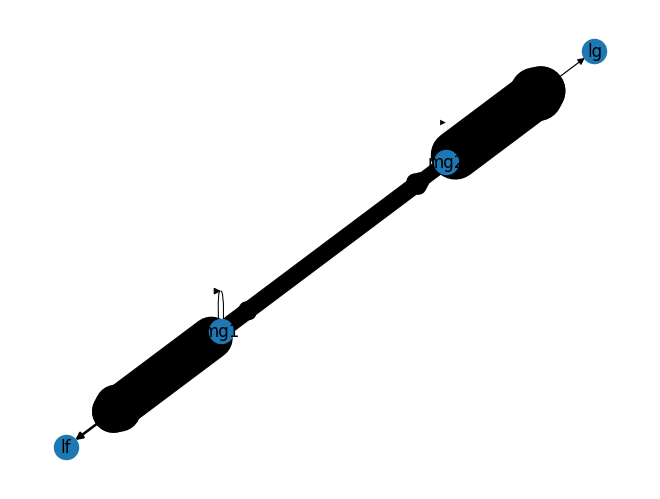

In [88]:
weights = nx.get_edge_attributes(subgraph,'weight').values()

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos,  
        width=list(weights),
        with_labels=True)


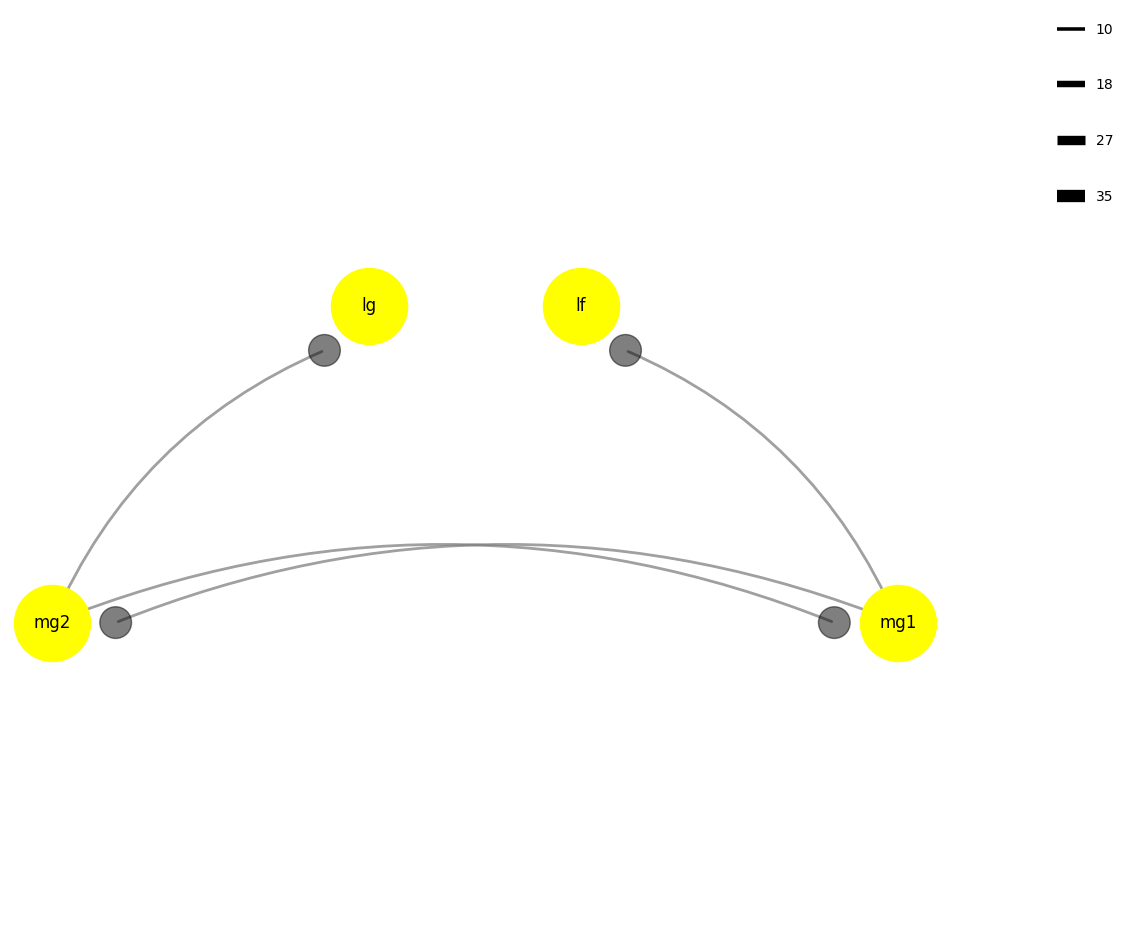

In [79]:
node_positions = {
    'aff': (3.5,1.5),
    'grc-s': (2,2.5),
    'grc-d': (5,2.5),
    'sgx2': (3,4),
    'sgx1': (4,4),
    'sg2': (1,4),
    'sg1': (6,4),
    'mg2': (1.5,5.5),
    'mg1': (5.5,5.5),
    'lg': (3,7),
    'lf': (4,7),
    'dml': (0.5,4.5),
    'tsd': (6.5,4.5),
    
}

# subgraph = G
color_spec = {'mg1':'gray',
             'sg1':'red',
             'grc-s':'red',
             'mg2':'gray',
             'sg2':'blue',
             'grc-d':'blue',
             'dml':'gray',
             'sgx1':'red',
             'sgx2':'blue',
             'aff':'red'}

# pos = nx.circular_layout(G) #kamada_kawai_layout(G) #spring_layout(G)  # Position nodes using a layout
hfig,ax = plt.subplots(1,figsize=(12,12))

min_weight = 2
weight_scale = 0.25

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos=node_positions,node_color='yellow', node_size=3000)
# Draw node labels
node_labels = {node: node for node in subgraph.nodes()}  # Assuming node labels are the same as node names
nx.draw_networkx_labels(subgraph, pos=node_positions, labels=node_labels, font_size=12)

d_stop_short = 0.3
for u, v, d in subgraph.edges(data=True):
    if d['weight']>min_weight:
        start = node_positions[u]
        stop = point_on_line(node_positions[v], node_positions[u], d_stop_short)
        
        rad_arc = 0.2
        if u in ['mg2','sg2','sgx-2','grc-s']: rad_arc = -0.2

        # Draw a curved line (without arrowhead) between nodes 'a' and 'b'
        arrow = patches.FancyArrowPatch(posA=start,
                                posB=stop,
                                arrowstyle='-',
                                color=color_spec[u],
                                linewidth= 2, #d['weight']*weight_scale,
                                mutation_scale=20,
                                connectionstyle=f"arc3,rad={rad_arc}",
                                alpha=0.75, zorder=0)
        plt.gca().add_patch(arrow)

        # Draw a circle at the terminal point (b node) of the edge
        circle_radius = 0.075  # Radius of the circle
        if u!='aff':
            circle_fill=True
        if u=='aff':
            circle_fill = False  # Set to True for a filled circle, False for an empty circle
        circle_edge_width = 1  # Line width of the circle edge

        circle = plt.Circle(point_on_line(node_positions[v], node_positions[u], d_stop_short), 
                            circle_radius, fill=circle_fill, alpha = 0.5, facecolor= 'black', edgecolor='black', linewidth=circle_edge_width, zorder=2)
        plt.gca().add_patch(circle)
    
# Set aspect ratio to be equal to ensure the circle appears as a circle
plt.axis('equal')

# Set axis limits and turn off axis for a cleaner visualization
# plt.xlim(-0.5, 2.5)
# plt.ylim(-0.5, 0.5)
plt.axis('off')


edge_weights = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges() if subgraph[u][v]['weight']>min_weight}

# Create a custom legend for edge widths
min_weight = min(edge_weights.values())
max_weight = max(edge_weights.values())
num_levels = 4  # Number of levels in the legend
lines = []
edges_weight_list=[]
for i in range(num_levels):
    level_weight = min_weight + (i / (num_levels - 1)) * (max_weight - min_weight)
    lines.append(Line2D([],[], linewidth=level_weight*weight_scale, color='black',solid_capstyle='butt'))
    edges_weight_list.append(int(level_weight))

legend = plt.legend(lines, edges_weight_list, bbox_to_anchor=(1.2,1), frameon=False,labelspacing=3)#,prop={'solid_capstyle':'butt'}) 


# Show the plot
plt.show()


In [598]:
edge_weights

{('mg1', 'mg2'): 25.5,
 ('aff', 'mg2'): 6.5,
 ('aff', 'grc-d'): 21.4,
 ('aff', 'sg2'): 18.0,
 ('sg2', 'mg1'): 39.333333333333336,
 ('grc-s', 'mg2'): 41.0,
 ('sg1', 'mg2'): 119.0,
 ('sg1', 'grc-s'): 1.875,
 ('grc-d', 'mg1'): 33.666666666666664,
 ('grc-d', 'grc-s'): 25.125,
 ('grc-d', 'sg1'): 40.75}

# Graph with individual cells as nodes

allows to search paths through network using all connections in df_edges

Uses df_edges

In [13]:
def find_paths_with_limit(graph, max_steps, source = None, source_type=None, target=None, target_type=None):
    paths = []
                    
    if source_type!=None:
        for node in graph.nodes():
            if graph.nodes[node]['cell_type'] == source_type:
                
                if target_type!=None:
                    for target_node in find_nodes_by_cell_type(graph, target_type):
                        for path in nx.all_simple_paths(graph, source=node, target=target_node, cutoff=max_steps):
                            path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                            paths.append(path_with_types)
                            
                if target_type==None:
                    for path in nx.all_simple_paths(graph, source=node, target=target, cutoff=max_steps):
                        path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                        paths.append(path_with_types)
                        
    if source_type==None:
        
        if target_type!=None:
            for target_node in find_nodes_by_cell_type(graph, target_type):
                for path in nx.all_simple_paths(graph, source=source, target=target_node, cutoff=max_steps):
                    path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                    paths.append(path_with_types)

        if target_type==None:
            for path in nx.all_simple_paths(graph, source=source, target=target, cutoff=max_steps):
                path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                paths.append(path_with_types)
                   
    return paths

# Function to find nodes by cell type
def find_nodes_by_cell_type(graph, cell_type):
    nodes_with_cell_type = []
    for node in graph.nodes():
        if graph.nodes[node]['cell_type'] == cell_type:
            nodes_with_cell_type.append(node)
    return nodes_with_cell_type

In [14]:
df_edges.head()

,pre,post,post_type,pre_type,weight
0,23379765,128832297,sg1,pe,1
1,23379765,218095913,sg2,pe,1
2,23379765,299496636,mg1,pe,2
3,23379765,305051491,grc-s,pe,1
4,23379765,389812730,grc-s,pe,1


In [17]:
nodes_to_graph = set(df_edges['pre'].unique())|set(df_edges['post'].unique())

G = nx.DiGraph()

# Add nodes with unique IDs and cell_type attribute
for k in nodes_to_graph:
    G.add_node(k, cell_type=cell_types[k])
# Add more nodes as needed

# Add edges between nodes (neurons
for index, row in df_edges.iterrows():
    pre_type = row['pre']
    post_type = row['post']
    weight = row['weight']
    
    # if cell_types[post_type] in ['lg','lf']:
    G.add_edge(pre_type, post_type, weight=weight)
    #     if syn == 'pre-synaptic':
    #         G.add_edge(post_type, pre_type, weight=weight)
    #     if syn == 'post-synaptic':
    #         G.add_edge(pre_type, post_type, weight=weight)

# degree

In [101]:
degree_in = dict(G.in_degree())
degree_in = [v for k,v in degree_in.items()]

degree_out = dict(G.out_degree())
nodes = [k for k,v in degree_out.items()]
degree_out = [v for k,v in degree_out.items()]


df_degree = pd.DataFrame({
    'cell_id': nodes,
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_types[k] for k in nodes]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

,cell_id,converge,diverge,type
0,558254086,0,0,mg2
1,300226567,0,8,mg2
...,...,...,...,...
177,472517114,0,0,mg2
178,390294014,0,9,mg2


<AxesSubplot:xlabel='type', ylabel='diverge'>

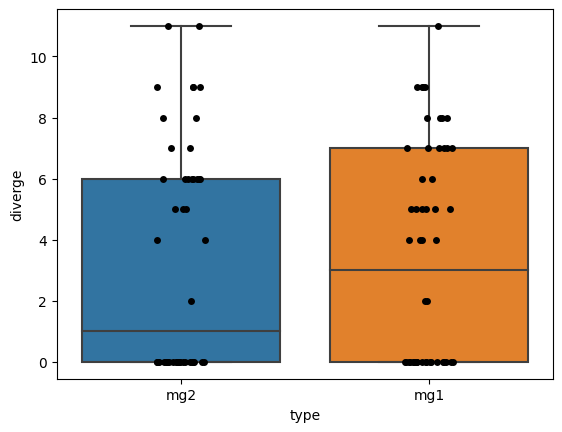

In [107]:
sns.boxplot(data=df_degree[df_degree['type'].isin(['mg1','mg2'])],y='diverge',x='type')
sns.stripplot(data=df_degree[df_degree['type'].isin(['mg1','mg2'])],y='diverge',x='type',color='black')

# adjacency matrix

In [37]:
nlist = []
tlist = ['mg1','mg2','lg','lf']
for t in tlist:
    for i in G.nodes():
        if G.nodes[i]['cell_type']==t:
            nlist.append(i)

In [54]:
nm1 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['mg1']])
nm2 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['mg2']])
no1 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['lg']])
no2 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['lf']])
nt = nm1+nm2+no1+no2

In [55]:
nt

179

In [61]:
A = nx.to_numpy_array(G,nodelist=nlist,nonedge=np.NaN)

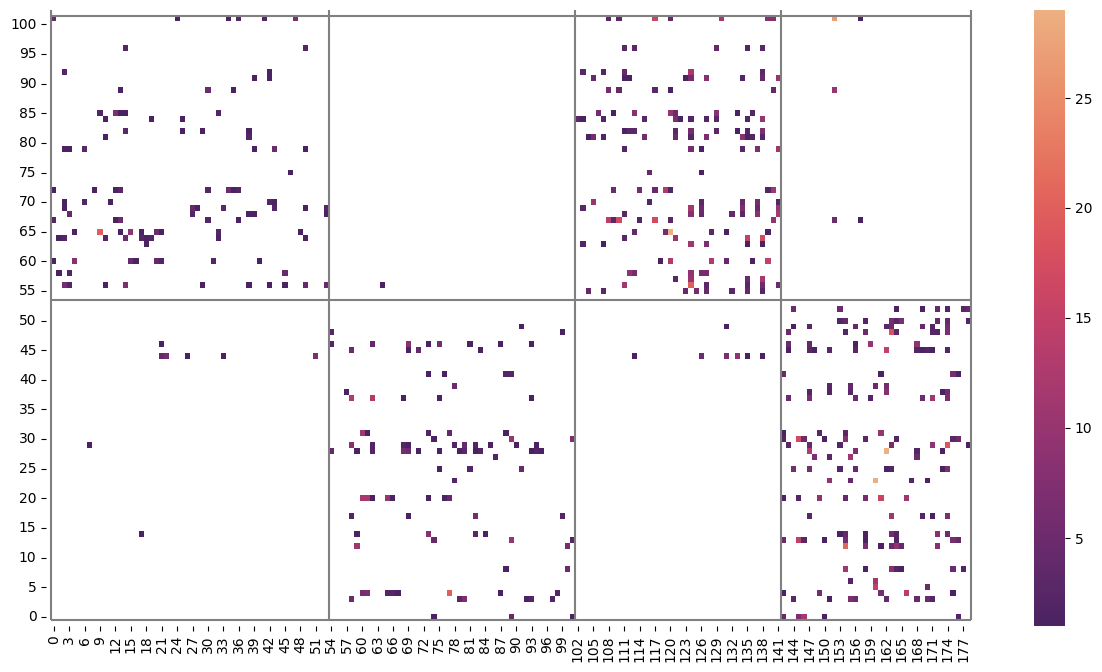

In [80]:
hfig,ax = plt.subplots(1,figsize=(15,8))
sns.heatmap(A,ax=ax,cmap='flare_r')
plt.ylim(-1,nm1+nm2+1)
plt.xlim(-1,nt+1)

ax.hlines([nm1,0,nm1+nm2],0,nt,color='gray')
ax.vlines([0,nm1,nm1+nm2,nm1+nm2+no1,nt],0,nt,color='gray')
# ax.hlines(nm2)

# If need subgraph

Based on type or cellids

In [249]:
sub_df = df_edges[(df_edges['pre'].isin(msg_extra_pfs)) & df_edges['post_type'].isin(['mg2','mg1','lf','lg','sg1','sg2'])]
nodes_to_graph = set(sub_df['pre'].unique())|set(sub_df['post'].unique())

G = nx.DiGraph()

# Add nodes with unique IDs and cell_type attribute
for k in nodes_to_graph:
    G.add_node(k, cell_type=cell_types[k])
# Add more nodes as needed

# Add edges between nodes (neurons
for index, row in sub_df.iterrows():
    pre_type = row['pre']
    post_type = row['post']
    weight = row['weight']

    G.add_edge(pre_type, post_type, weight=weight)

# Get paths

In [20]:
mg_example_id = 214581797
target_in_type = 'aff'

paths_pf_mg = find_paths_with_limit(G, max_steps=1, source=216994785, target=mg_example_id) #target_type='mg1') #
paths_pf_mg

[[(216994785, 'sg1'), (214581797, 'mg2')]]

# Quantify Redundant connections

## example cells

## mg

In [304]:
## Example mg1 299496636
## Example mg2 214581797

mg_example_id = 299496636
target_out_type = 'lf'

paths_pf_mg = find_paths_with_limit(G, max_steps=1, source_type='pf', target=mg_example_id) #target_type='mg1') #
paths_pf_mg

## Example lf
# paths = find_paths_with_limit(G, max_steps=2, source_type='pf', target=393325331)
# paths

[[(369312699, 'pf'), (299496636, 'mg1')],
 [(282137001, 'pf'), (299496636, 'mg1')],
 [(283546452, 'pf'), (299496636, 'mg1')],
 [(283546587, 'pf'), (299496636, 'mg1')],
 [(283547027, 'pf'), (299496636, 'mg1')],
 [(283408822, 'pf'), (299496636, 'mg1')],
 [(283548237, 'pf'), (299496636, 'mg1')],
 [(283409058, 'pf'), (299496636, 'mg1')],
 [(283548467, 'pf'), (299496636, 'mg1')],
 [(282402582, 'pf'), (299496636, 'mg1')]]

In [305]:
# make sure the pf is one of the specific "pre-synaptic" ones from the example cells
# can also filter by y position in volume

In [306]:
pf_pre = [p[0][0] for p in paths_pf_mg]

In [307]:
paths_pf_output = []
for pf_ in pf_pre:
    paths_pf_output.extend(find_paths_with_limit(G, max_steps=1, source=pf_, target_type=target_out_type))

In [308]:
paths_pf_output

[[(369312699, 'pf'), (393325331, 'lf')],
 [(282137001, 'pf'), (134616493, 'lf')],
 [(283546452, 'pf'), (393464000, 'lf')],
 [(283546587, 'pf'), (393464000, 'lf')],
 [(283548237, 'pf'), (393464000, 'lf')],
 [(283409058, 'pf'), (393325331, 'lf')],
 [(283548467, 'pf'), (306567106, 'lf')]]

In [309]:
# output that get input from those pf
print(f'{len(set([p[1][0] for p in paths_pf_output]))} output get input from these pfs; ids = {set([p[1][0] for p in paths_pf_output])}')

4 output get input from these pfs; ids = {393464000, 306567106, 393325331, 134616493}


In [310]:
paths_mg_output = find_paths_with_limit(G, max_steps=1, source=mg_example_id, target_type=target_out_type)

In [311]:
paths_mg_output

[[(299496636, 'mg1'), (565183253, 'lf')],
 [(299496636, 'mg1'), (393464000, 'lf')],
 [(299496636, 'mg1'), (564038367, 'lf')],
 [(299496636, 'mg1'), (393325331, 'lf')],
 [(299496636, 'mg1'), (392072123, 'lf')],
 [(299496636, 'mg1'), (134616493, 'lf')],
 [(299496636, 'mg1'), (307418797, 'lf')]]

In [312]:
# output that get input from the example mg
print(f'this example mg contacts the following output: {set([p[1][0] for p in paths_mg_output])}')

this example mg contacts the following output: {393464000, 134616493, 307418797, 393325331, 565183253, 392072123, 564038367}


In [313]:
pf_shared = [p[0][0] for p in paths_pf_output if p[1][0] in list(set([p[1][0] for p in paths_mg_output]))]

In [314]:
print(f'{len(pf_pre)} pfs pre to this mg; {len(pf_shared)} of them are shared with an output cell postsyn to this mg')

10 pfs pre to this mg; 6 of them are shared with an output cell postsyn to this mg


In [315]:
# output cells that do not already get input from the mg example cell
output_unshared = set([p[1][0] for p in paths_pf_output]) - set([p[1][0] for p in paths_mg_output])
print(f'These pfs contact {len(output_unshared)} output cell(s) that do not get input from the example mg; independent output ids = {output_unshared}')

These pfs contact 1 output cell(s) that do not get input from the example mg; independent output ids = {306567106}


### Visualize subgraph

In [279]:
subgraph_nodes = []
subgraph_nodes.extend([mg_example_id])
subgraph_nodes.extend([p[0][0] for p in paths_pf_mg])
subgraph_nodes.extend([p[1][0] for p in paths_pf_output])
subgraph_nodes.extend([p[1][0] for p in paths_mg_output])

In [280]:
subgraph_nodes

[214581797,
 369312115,
 636004167,
 368151126,
 368151599,
 282137001,
 283409102,
 386363638,
 644112836,
 645162652,
 300474334,
 300474334,
 644112836,
 44933647,
 302637877,
 301787806,
 129838223,
 303086200,
 302637877,
 645162652,
 301787806,
 214503199,
 558020412]

In [281]:
subgraph = G.subgraph(set(subgraph_nodes))

In [282]:
# Find all simple paths in the subgraph
all_paths = []
for source in subgraph.nodes():
    for target in subgraph.nodes():
        if source != target:
            paths = nx.all_simple_paths(subgraph, source=source, target=target)
            path_with_types = []
            for path in paths:
                path_with_types = [(n, subgraph.nodes[n]['cell_type']) for n in path]
            all_paths.append(path_with_types)

# print(all_paths)

# for path in nx.all_simple_paths(graph, source=source, target=target, cutoff=max_steps):
#                 path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
#                 paths.append(path_with_types)

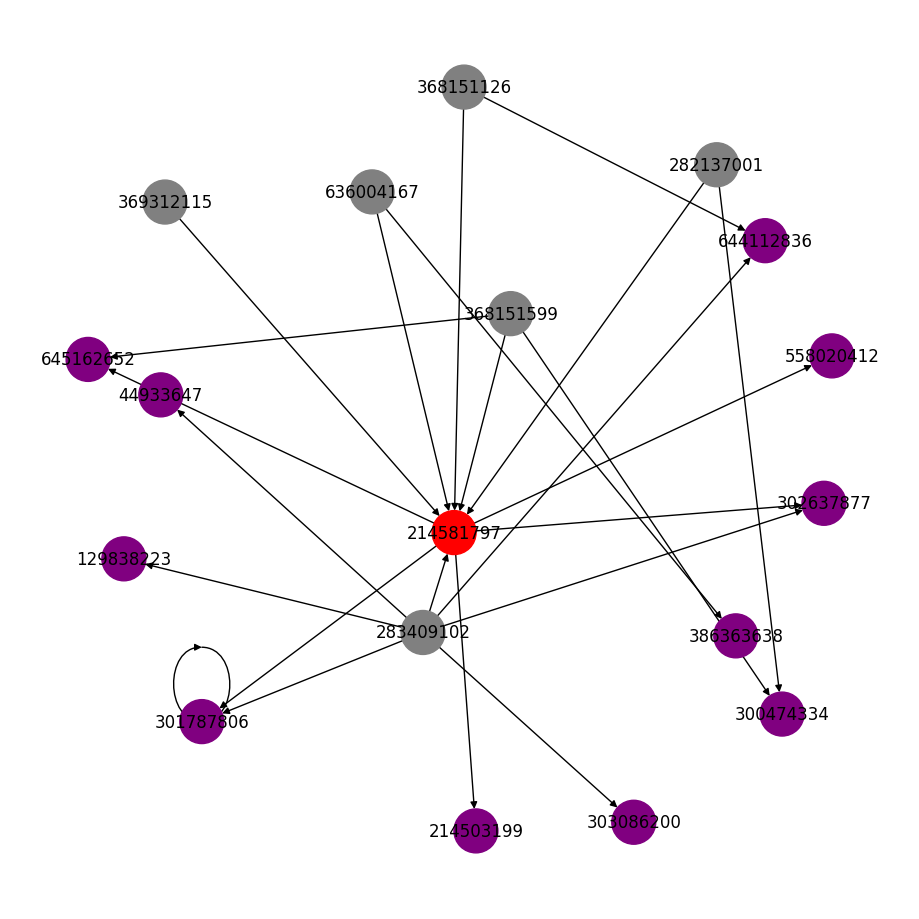

In [283]:
# Create a new figure for the graph
plt.figure(figsize=(9,9))

# # Create a subgraph with only nodes in the paths
# subgraph_nodes = set(node[0] for path in paths for node in path)
# subgraph = G.subgraph(subgraph_nodes)

# Get node colors based on node_name
node_colors = {node[0]: 'gray' if node[1] == 'pf' 
               else 'red' if node[1] == 'mg2' 
               else 'magenta' if node[1] == 'sg2'
               else 'purple' if node[1] == 'lg'
               else 'blue' if node[1] == 'mg1'
               else 'cyan' if node[1] == 'sg1'
               else 'orange' if node[1] == 'lf' 
               else 'black'
               for path in all_paths for node in path}

# Get edge colors based on the starting node's node_name
edge_colors = {edge[0][0]: node_colors[edge[0][0]] for path in paths for edge in zip(path, path[1:])}


# Manually set node positions in concentric circles
lg_nodes = [node for node, name in node_colors.items() if name == 'purple']
mg2_nodes = [node for node, name in node_colors.items() if name == 'red']
sg2_nodes = [node for node, name in node_colors.items() if name == 'magenta']
lf_nodes = [node for node, name in node_colors.items() if name == 'orange']
mg1_nodes = [node for node, name in node_colors.items() if name == 'blue']
sg1_nodes = [node for node, name in node_colors.items() if name == 'cyan']
pf_nodes = [node for node, name in node_colors.items() if name == 'gray']
other_nodes = [node for node, name in node_colors.items() if name == 'black']

pos_specs = {
    'lf':(4,lf_nodes),
    'lg':(4,lg_nodes),
    'mg1':(0,mg1_nodes),
    'mg2':(0,mg2_nodes),
    'sg1':(5,sg1_nodes),
    'sg2':(5.5,sg2_nodes),
    'pf':(6,pf_nodes)
}

pos = {}

for k,v in pos_specs.items():
    
    radius = v[0]#int(k)  # Adjust the radius based on your preference
    node_list = v[1]
    theta = np.linspace(0, 2 * np.pi, len(node_list), endpoint=False) + random.random()
    for i, node in enumerate(node_list):
        pos[node] = (radius * np.cos(theta[i]), radius * np.sin(theta[i]))

# Draw the subgraph with node and edge colors
nx.draw(subgraph, pos=nx.spring_layout(subgraph,k=2), with_labels=True, node_color=[node_colors[node] for node in subgraph.nodes()], node_size=1000)

# Plot each path on top of the subgraph with specified edge colors
# for path in paths:
#     edges = [(path[i][0], path[i + 1][0]) for i in range(len(path) - 1)]
#     nx.draw_networkx_edges(subgraph, pos= nx.spring_layout(subgraph,k=2), edgelist=edges, edge_color=[edge_colors[edge[0][0]] for edge in zip(path, path[1:])], width=1)

# Display the subgraph
plt.show()

## output

In [389]:
## Example lf 393325331 (pre would be mg1)
## Example lg 301787806 (pre would be mg2)

output_example_id = 393325331
mg_pre_type = 'mg1'

paths_output = find_paths_with_limit(G, max_steps=2, source_type='pf', target=output_example_id) #target_type='mg1') #

pf_pre = [p[0][0] for p in paths_output if len(p)==2]
print(pf_pre)

print(f'{len(pf_pre)} parallel fibers presynaptic to this example output')

[369312294, 369312360, 369312699, 369297193, 368151099, 368151126, 368151283, 368151599, 283409058]
9 parallel fibers presynaptic to this example output


In [390]:
# make sure the pf is one of the specific "pre-synaptic" ones from the example cells
# can also filter by y position in volume

In [391]:
[p for p in paths_output if (p[1][1] in ['mg1','mg2']) & (p[0][0] in pf_pre)]

[[(369312360, 'pf'), (128813171, 'mg1'), (393325331, 'lf')],
 [(369312699, 'pf'), (128737253, 'mg1'), (393325331, 'lf')],
 [(369312699, 'pf'), (299496636, 'mg1'), (393325331, 'lf')],
 [(369297193, 'pf'), (128813171, 'mg1'), (393325331, 'lf')],
 [(368151126, 'pf'), (128737253, 'mg1'), (393325331, 'lf')],
 [(368151283, 'pf'), (213669553, 'mg1'), (393325331, 'lf')],
 [(368151599, 'pf'), (128737253, 'mg1'), (393325331, 'lf')],
 [(368151599, 'pf'), (128813171, 'mg1'), (393325331, 'lf')],
 [(368151599, 'pf'), (642905044, 'mg1'), (393325331, 'lf')],
 [(283409058, 'pf'), (213590737, 'mg1'), (393325331, 'lf')],
 [(283409058, 'pf'), (299496636, 'mg1'), (393325331, 'lf')]]

In [392]:
[p for p in paths_output if (p[1][1] in ['mg1','mg2']) & (p[0][0] not in pf_pre)]

[[(372899977, 'pf'), (126618353, 'mg1'), (393325331, 'lf')],
 [(369312115, 'pf'), (213501262, 'mg1'), (393325331, 'lf')],
 [(369312115, 'pf'), (299530386, 'mg1'), (393325331, 'lf')],
 [(282264725, 'pf'), (642905044, 'mg1'), (393325331, 'lf')],
 [(282248367, 'pf'), (128737253, 'mg1'), (393325331, 'lf')],
 [(282248367, 'pf'), (213501262, 'mg1'), (393325331, 'lf')],
 [(282137001, 'pf'), (299496636, 'mg1'), (393325331, 'lf')],
 [(283546452, 'pf'), (213669553, 'mg1'), (393325331, 'lf')],
 [(283546452, 'pf'), (299496636, 'mg1'), (393325331, 'lf')],
 [(283546587, 'pf'), (126618353, 'mg1'), (393325331, 'lf')],
 [(283546587, 'pf'), (299496636, 'mg1'), (393325331, 'lf')],
 [(283547027, 'pf'), (299496636, 'mg1'), (393325331, 'lf')],
 [(283408821, 'pf'), (644005141, 'mg1'), (393325331, 'lf')],
 [(283408822, 'pf'), (299496636, 'mg1'), (393325331, 'lf')],
 [(283548237, 'pf'), (213590737, 'mg1'), (393325331, 'lf')],
 [(283548237, 'pf'), (213760634, 'mg1'), (393325331, 'lf')],
 [(283548237, 'pf'), (29

In [393]:
shared_pf = set([p[0][0] for p in paths_output if (p[1][1] in ['mg1','mg2']) & (p[0][0] in pf_pre)])

extended_pf = set([p[0][0] for p in paths_output if (p[1][1] in ['mg1','mg2']) & (p[0][0] not in pf_pre)])

In [394]:
print(f'{len(shared_pf)} pf that are also shared with pre-synaptic mg cells')
print(f'{len(extended_pf)} pf that it can learn from via pre-synaptic mg cells that it would otherwise not get (no direct connection to the pf)')

7 pf that are also shared with pre-synaptic mg cells
15 pf that it can learn from via pre-synaptic mg cells that it would otherwise not get (no direct connection to the pf)


In [395]:
paths_mg_output = find_paths_with_limit(G, max_steps=1, source_type=mg_pre_type, target=output_example_id) #target_type='mg1') #

In [396]:
paths_mg_output

[[(213590737, 'mg1'), (393325331, 'lf')],
 [(213501262, 'mg1'), (393325331, 'lf')],
 [(472409584, 'mg1'), (393325331, 'lf')],
 [(127870654, 'mg1'), (393325331, 'lf')],
 [(558360429, 'mg1'), (393325331, 'lf')],
 [(128813171, 'mg1'), (393325331, 'lf')],
 [(473647416, 'mg1'), (393325331, 'lf')],
 [(126618353, 'mg1'), (393325331, 'lf')],
 [(557092670, 'mg1'), (393325331, 'lf')],
 [(642905044, 'mg1'), (393325331, 'lf')],
 [(472175645, 'mg1'), (393325331, 'lf')],
 [(299496636, 'mg1'), (393325331, 'lf')],
 [(213669553, 'mg1'), (393325331, 'lf')],
 [(299530386, 'mg1'), (393325331, 'lf')],
 [(644143297, 'mg1'), (393325331, 'lf')],
 [(213760634, 'mg1'), (393325331, 'lf')],
 [(644005141, 'mg1'), (393325331, 'lf')],
 [(128737253, 'mg1'), (393325331, 'lf')]]

In [397]:
print(f'{len(set([p[0][0] for p in paths_mg_output]))} mg presynaptic to this output to collect pf synapses from')

18 mg presynaptic to this output to collect pf synapses from


In [403]:
subgraph_nodes = []
subgraph_nodes.extend([output_example_id]) # output cell example
subgraph_nodes.extend(pf_pre) # pfs pre to output
# subgraph_nodes.extend([p[1][0] for p in paths_output if (p[1][1] in ['mg1','mg2']) & (p[0][0] in pf_pre)]) # mg sharing pf input
# subgraph_nodes.extend([p[0][0] for p in paths_mg_output]) # all mg pre
# subgraph_nodes.extend([p[1][0] for p in paths_mg_output])


In [404]:
set(subgraph_nodes)

{283409058,
 368151099,
 368151126,
 368151283,
 368151599,
 369297193,
 369312294,
 369312360,
 369312699,
 393325331}

In [400]:
subgraph = G.subgraph(set(subgraph_nodes))

In [401]:
# Find all simple paths in the subgraph
all_paths = []
for source in subgraph.nodes():
    for target in subgraph.nodes():
        if source != target:
            paths = nx.all_simple_paths(subgraph, source=source, target=target)
            path_with_types = []
            for path in paths:
                path_with_types = [(n, subgraph.nodes[n]['cell_type']) for n in path]
            all_paths.append(path_with_types)

# print(all_paths)

# for path in nx.all_simple_paths(graph, source=source, target=target, cutoff=max_steps):
#                 path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
#                 paths.append(path_with_types)

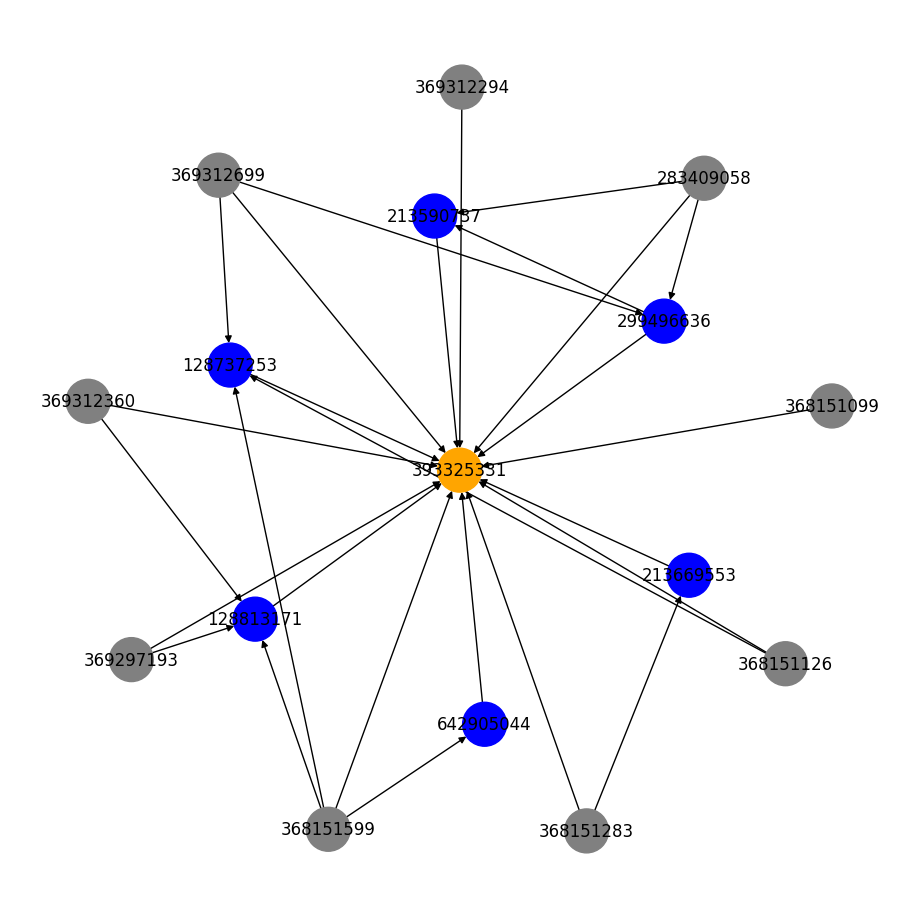

In [402]:
# Create a new figure for the graph
plt.figure(figsize=(9,9))

# # Create a subgraph with only nodes in the paths
# subgraph_nodes = set(node[0] for path in paths for node in path)
# subgraph = G.subgraph(subgraph_nodes)

# Get node colors based on node_name
node_colors = {node[0]: 'gray' if node[1] == 'pf' 
               else 'red' if node[1] == 'mg2' 
               else 'magenta' if node[1] == 'sg2'
               else 'purple' if node[1] == 'lg'
               else 'blue' if node[1] == 'mg1'
               else 'cyan' if node[1] == 'sg1'
               else 'orange' if node[1] == 'lf' 
               else 'black'
               for path in all_paths for node in path}

# Get edge colors based on the starting node's node_name
edge_colors = {edge[0][0]: node_colors[edge[0][0]] for path in paths for edge in zip(path, path[1:])}


# Manually set node positions in concentric circles
lg_nodes = [node for node, name in node_colors.items() if name == 'purple']
mg2_nodes = [node for node, name in node_colors.items() if name == 'red']
sg2_nodes = [node for node, name in node_colors.items() if name == 'magenta']
lf_nodes = [node for node, name in node_colors.items() if name == 'orange']
mg1_nodes = [node for node, name in node_colors.items() if name == 'blue']
sg1_nodes = [node for node, name in node_colors.items() if name == 'cyan']
pf_nodes = [node for node, name in node_colors.items() if name == 'gray']
other_nodes = [node for node, name in node_colors.items() if name == 'black']

pos_specs = {
    'lf':(0,lf_nodes),
    'lg':(0,lg_nodes),
    'mg1':(4,mg1_nodes),
    'mg2':(4,mg2_nodes),
    'sg1':(5,sg1_nodes),
    'sg2':(5.5,sg2_nodes),
    'pf':(6,pf_nodes)
}

pos = {}

for k,v in pos_specs.items():
    
    radius = v[0]#int(k)  # Adjust the radius based on your preference
    node_list = v[1]
    theta = np.linspace(0, 2 * np.pi, len(node_list), endpoint=False) + random.random()
    for i, node in enumerate(node_list):
        pos[node] = (radius * np.cos(theta[i]), radius * np.sin(theta[i]))

# Draw the subgraph with node and edge colors
nx.draw(subgraph, pos, with_labels=True, node_color=[node_colors[node] for node in subgraph.nodes()], node_size=1000)

# Plot each path on top of the subgraph with specified edge colors
# for path in paths:
#     edges = [(path[i][0], path[i + 1][0]) for i in range(len(path) - 1)]
#     nx.draw_networkx_edges(subgraph, pos= nx.spring_layout(subgraph,k=2), edgelist=edges, edge_color=[edge_colors[edge[0][0]] for edge in zip(path, path[1:])], width=1)

# Display the subgraph
plt.show()

## PLot subgraphs with nodes determined by sets of paths

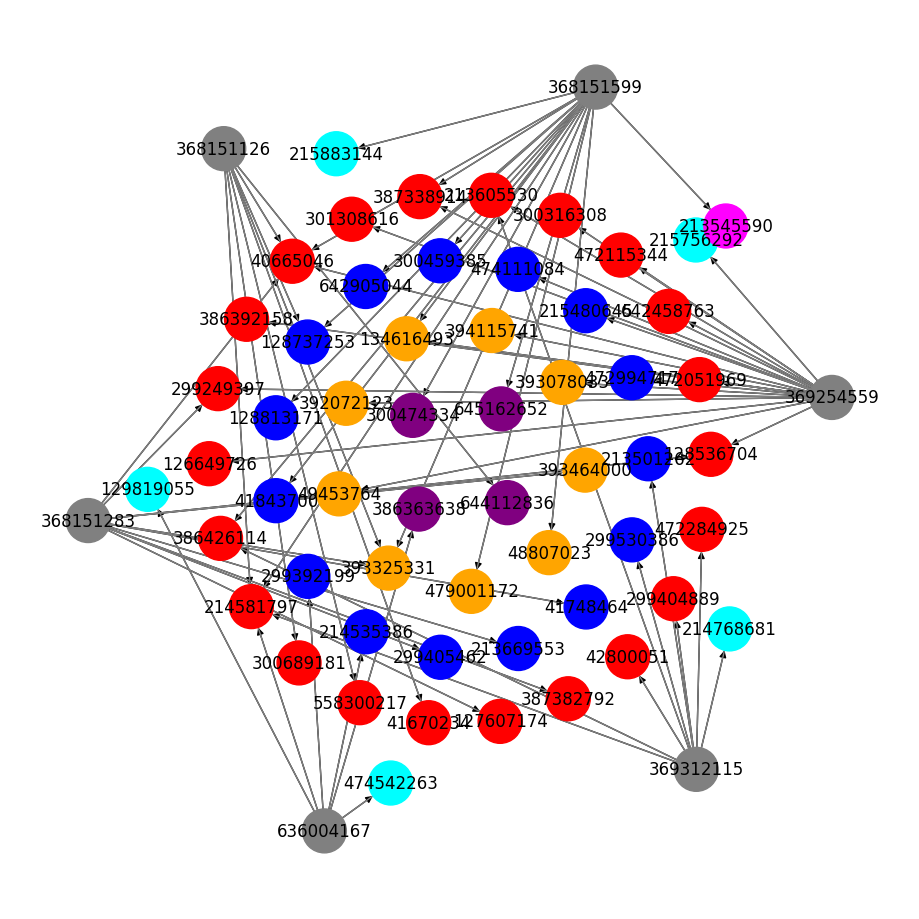

In [257]:
# Create a new figure for the graph
plt.figure(figsize=(9,9))

# Create a subgraph with only nodes in the paths
subgraph_nodes = set(node[0] for path in paths for node in path)
subgraph = G.subgraph(subgraph_nodes)

# Get node colors based on node_name
node_colors = {node[0]: 'gray' if node[1] == 'pf' 
               else 'red' if node[1] == 'mg2' 
               else 'magenta' if node[1] == 'sg2'
               else 'purple' if node[1] == 'lg'
               else 'blue' if node[1] == 'mg1'
               else 'cyan' if node[1] == 'sg1'
               else 'orange' if node[1] == 'lf' 
               else 'black'
               for path in paths for node in path}

# Get edge colors based on the starting node's node_name
edge_colors = {edge[0][0]: node_colors[edge[0][0]] for path in paths for edge in zip(path, path[1:])}


# Manually set node positions in concentric circles
lg_nodes = [node for node, name in node_colors.items() if name == 'purple']
mg2_nodes = [node for node, name in node_colors.items() if name == 'red']
sg2_nodes = [node for node, name in node_colors.items() if name == 'magenta']
lf_nodes = [node for node, name in node_colors.items() if name == 'orange']
mg1_nodes = [node for node, name in node_colors.items() if name == 'blue']
sg1_nodes = [node for node, name in node_colors.items() if name == 'cyan']
pf_nodes = [node for node, name in node_colors.items() if name == 'gray']
other_nodes = [node for node, name in node_colors.items() if name == 'black']

pos_specs = {
    'lf':(2,lf_nodes),
    'lg':(1,lg_nodes),
    'mg1':(3,mg1_nodes),
    'mg2':(4,mg2_nodes),
    'sg1':(5,sg1_nodes),
    'sg2':(5.5,sg2_nodes),
    'pf':(6,pf_nodes)
}

pos = {}

for k,v in pos_specs.items():
    
    radius = v[0]#int(k)  # Adjust the radius based on your preference
    node_list = v[1]
    theta = np.linspace(0, 2 * np.pi, len(node_list), endpoint=False) + random.random()
    for i, node in enumerate(node_list):
        pos[node] = (radius * np.cos(theta[i]), radius * np.sin(theta[i]))

# Draw the subgraph with node and edge colors
nx.draw(subgraph, pos, with_labels=True, node_color=[node_colors[node] for node in subgraph.nodes()], node_size=1000)

# Plot each path on top of the subgraph with specified edge colors
for path in paths:
    edges = [(path[i][0], path[i + 1][0]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, edge_color=[edge_colors[edge[0][0]] for edge in zip(path, path[1:])], width=1)

# Display the subgraph
plt.show()

In [37]:
df_syn_pre = pd.read_csv(dirpath / 'graphs/df_presyn.csv')

df_edges_pre=df_syn_pre.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

lg_pre_sg_mg = df_edges_pre[(df_edges_pre['pre'].isin([301787806])) & (df_edges_pre['post_type'].isin(['sg2','mg2']))]['post'].values

In [46]:
paths = find_paths_with_limit(G, max_steps=1, source_type='pf', target_type='mg2')

paths = [p for p in paths if p[0][0] in lg_pfs]

print(f'{len(paths)} mg2 postsyn to pfs that target example lg')

print(f'{len([p for p in paths if p[1][0] in lg_pre_sg_mg])} of these are mg2 that are also presyn to the lg')

print([p for p in paths if p[1][0] in lg_pre_sg_mg])
# mg2_pfs_pre 

7 mg2 postsyn to pfs that target example lg
3 of these are mg2 that are also presyn to the lg
[[(297177312, 'pf'), (299404889, 'mg2')], [(282249203, 'pf'), (40665046, 'mg2')], [(283409058, 'pf'), (472361842, 'mg2')]]


In [47]:
paths = find_paths_with_limit(G, max_steps=1, source_type='pf', target_type='sg2')

paths = [p for p in paths if p[0][0] in lg_pfs]

print(f'{len(paths)} sg2 postsyn to pfs that target example lg')

print(f'{len([p for p in paths if p[1][0] in lg_pre_sg_mg])} of these are sg2 that are also presyn to the lg')

print([p for p in paths if p[1][0] in lg_pre_sg_mg])
# mg2_pfs_pre 

1 sg2 postsyn to pfs that target example lg
0 of these are sg2 that are also presyn to the lg
[]


In [39]:
paths = find_paths_with_limit(G, max_steps=1, source_type='pf', target_type='sg2')

paths

[[(282264725, 'pf'), (216952227, 'sg2')],
 [(368151599, 'pf'), (213545590, 'sg2')],
 [(634858913, 'pf'), (475688080, 'sg2')]]

In [37]:
grcs_cells = list(set([l[0][0] for l in paths]))

In [42]:
len(grcs_cells)

13

In [19]:
c_id = [l[1][0] for l in paths]
c_t = [l[1][1] for l in paths]

In [28]:
pd.DataFrame({'id':c_id,'type':c_t}).drop_duplicates(ignore_index=True).groupby(['type']).count()

,id
type,
grc-d,3
mg2,2
sg2,2
sgx2,1


In [46]:
find_paths_with_limit(G, max_steps=1, source_type='aff', target_type = 'grc-d')

[[(55472256, 'aff'), (226019332, 'grc-d')],
 [(55472256, 'aff'), (228366816, 'grc-d')],
 [(56553977, 'aff'), (226019332, 'grc-d')],
 [(60129918, 'aff'), (223881844, 'grc-d')],
 [(60129918, 'aff'), (482680782, 'grc-d')],
 [(60159066, 'aff'), (482680782, 'grc-d')],
 [(223835257, 'aff'), (481412554, 'grc-d')],
 [(223835257, 'aff'), (227254070, 'grc-d')],
 [(223835257, 'aff'), (482680782, 'grc-d')],
 [(400258384, 'aff'), (482680782, 'grc-d')],
 [(60192229, 'aff'), (223881844, 'grc-d')],
 [(60192229, 'aff'), (482680782, 'grc-d')],
 [(60081840, 'aff'), (223881844, 'grc-d')],
 [(60081840, 'aff'), (482680782, 'grc-d')],
 [(54372224, 'aff'), (226019332, 'grc-d')],
 [(54372224, 'aff'), (228366816, 'grc-d')],
 [(666982330, 'aff'), (481412554, 'grc-d')],
 [(60143700, 'aff'), (483689146, 'grc-d')],
 [(60143700, 'aff'), (481412554, 'grc-d')],
 [(57714981, 'aff'), (226019332, 'grc-d')],
 [(57714981, 'aff'), (228366816, 'grc-d')],
 [(56662421, 'aff'), (226019332, 'grc-d')],
 [(56662421, 'aff'), (22836

In [47]:
grc_cells = [483689146,481412554]

In [ ]:
source_type = 'aff'
target_type = 'lg'
max_steps = 3  # Maximum number of steps in the path

paths = find_paths_with_limit(G, max_steps, source_type=source_type, target_type=target_type)

paths

In [824]:
sg2_cells = [l_[0][0] for l_ in paths]

In [ ]:
source_type = 'grc-d'
target_type = 'lg'
max_steps = 1  # Maximum number of steps in the path

paths = find_paths_with_limit(G, max_steps, source_type, target_type)
paths


In [817]:
grcd_cells = [l_[0][0] for l_ in paths]

## visualize cell structure by type

requires cell structure labeling to be done 

In [408]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffffff',#'#ffc0cb',
    'tsd':'#737373',
    'pf':'#cccccc'
}

In [431]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

## whole cells

In [453]:
cells_to_vis = [
    # 283409058,
    # 368151099,
    # 368151126,
    # 368151283,
    # 368151599,
    # 369297193,
    # 369312294,
    # 369312360,
    # 369312699,
    393325331]

cells_to_vis = [369297193, 368151283]

In [454]:
color_pal = sns.color_palette("bright", as_cmap=True)
# sns.color_palette("hls", 10)

c_map = {c_id:c_ for c_id,c_ in zip(cells_to_vis,color_pal)}

In [455]:
segs_to_add = {}
# structure_label = 'basal dendrite'
for c_id in cells_to_vis: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    # if cell.cell_data['base_segments'][structure_label] != set():
    segs_to_add[c_id] = cell.cell_data['base_segments']#[structure_label] #[a for b in cell.cell_data['base_segments'].values() for a in b]

# each cell to same tab
# lname = str(c_id) + '_' + 'grcs'
# create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)

# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    lname = str(c_id) + '_' + cell_types[c_id]
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    with viewer.txn(overwrite=True) as s:
        for k,b in b_.items():
            # if k=='apical dendrite':

            for bs in b: 
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = c_map[c_id]#syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

In [460]:
# synapse annotations from cells
anno_t = 'post-synaptic' #'uncertain'#

for c_id in cells_to_vis: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    lname = f'{c_id} {anno_t}'
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.AnnotationLayer()
        s.layers[lname].annotationColor = '#ff00ff'#'#ff0000'#

        for pos, point in enumerate(cell.cell_data['end_points'][anno_t]): 
            
            point_array = array([int(point[i]/vx_sizes[i]) for i in range(3)])#[point[x] for x in ['x','y','z']]) #array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{anno_t}_{pos}'
                # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname].annotations.append(pa)    

add pre cell basal dendrites

In [ ]:
segs_to_add = {}
structure_label = 'basal dendrite'
for c_id in grc_cells: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    if cell.cell_data['base_segments'][structure_label] != set():
        segs_to_add[c_id] = cell.cell_data['base_segments'][structure_label] #[a for b in cell.cell_data['base_segments'].values() for a in b]

# each cell to same tab
lname = str(c_id) + '_' + 'grcs'
create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)

# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    # lname = str(c_id) + '_' + cell_types[c_id]
    # create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    with viewer.txn(overwrite=True) as s:
        for bs in b_: 
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

add afferents

In [48]:
aff_cells = [61319896]
aff_cells = grc_cells

In [49]:
segs_to_add = {}
for c_id in aff_cells: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    if cell.cell_data['base_segments'] != set():
        segs_to_add[c_id] = cell.cell_data['base_segments'] #[a for b in cell.cell_data['base_segments'].values() for a in b]

## add each cell to the same tab
# lname = str(c_id) + '_' + 'aff'
# create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    
# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    lname = str(c_id) + '_' + cell_types[c_id]
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    with viewer.txn(overwrite=True) as s:
        for k,v in b_.items(): 
            for bs in v:
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

add target cell basal dendrites

In [54]:
target_cell = 301787806
segs_to_add = {}
structure_label = 'basal dendrite'
for c_id in [target_cell]: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    if cell.cell_data['base_segments'][structure_label] != set():
        segs_to_add[c_id] = cell.cell_data['base_segments'][structure_label] #[a for b in cell.cell_data['base_segments'].values() for a in b]
    

# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    lname = str(c_id) #+ '_' + cell.get_ctype('manual')
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    with viewer.txn(overwrite=True) as s:
        for bs in b_: 
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = 'black'#syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)